In [432]:
###Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from IPython.display import Image
from IPython.core.display import HTML
import datetime
import math
import scipy.optimize as optimize
import statistics
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy import stats
import scipy
import warnings
from scipy.stats import norm
from sklearn import datasets, linear_model, cross_validation
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold 
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
from IPython.display import Image
from IPython.core.display import HTML 
import xgboost
from pprint import pprint

In [53]:
### data loading 
df = pd.read_csv('./data/loan.csv', low_memory=False)

In [54]:
### data loading & cleaning
df = df.drop_duplicates(subset='id').reset_index(drop=True)
df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['id', 'funded_amnt','int_rate','installment','grade'])
df = df[np.isfinite(df['annual_inc']) & np.isfinite(df['int_rate']) &  np.isfinite(df['funded_amnt'])].copy()

In [244]:
###changing data type to appropriate date type 
df['last_pymnt_d']=pd.to_datetime(df.last_pymnt_d)
df['issue_d']=pd.to_datetime(df.issue_d)
df['earliest_cr_line']= pd.to_datetime(df.earliest_cr_line)

In [56]:
###fill missing last_payments(no payments) with issue date, may want a separete column for this treatment
###This is for calculation of IRRs later
df['last_pymnt_d'].fillna(df.issue_d,inplace=True)

In [57]:
###Some pre-processing for ease of calculations
df['issue_yr'] = df.issue_d.dt.year
df['issue_mo']= df.issue_d.dt.month
df['last_pymnt_yr'] = df.last_pymnt_d.dt.year
df['last_pymnt_mo']= df.last_pymnt_d.dt.month
df['mo_diff'] = pd.to_numeric((df['last_pymnt_yr'] - 
                          df['issue_yr'])*12 + df['last_pymnt_mo'] -df['issue_mo'])

In [349]:
###Credit History Length
df['cl_yr'] = df.earliest_cr_line.dt.year
df['cl_mo']= df.earliest_cr_line.dt.month
df['cl_hist'] = pd.to_numeric((df['issue_yr'] - 
                          df['cl_yr'])*12 + df['issue_mo'] -df['cl_mo'])

In [350]:
###Flag for completed loans
searchfor = ['Fully Paid', 'Charged Off', 'Default']
defaults = ['Charged Off', 'Default']
df['loan_completion_flag']=  np.where(df['loan_status'].str.contains('|'.join(searchfor)) ,1, np.nan)
###Flag for fully paid loans
df['fully_paid'] = np.where(df['loan_status'].str.contains('Fully Paid') ,1, 
                                  np.where(df['loan_status'].str.contains('|'.join(defaults)) ,0,np.nan))


In [351]:
###Average payment = Total payment - recoveries - last payment amount over the life -1 month of the investment
df['avg_pymnt'] = (df['total_pymnt']-df['recoveries']-df['last_pymnt_amnt'])/(np.maximum((df['mo_diff']-1),0))
###Treating infinites that appear when there is no payment or only 1 payment 
df['avg_pymnt'] = (df['avg_pymnt']).replace(np.Inf,0)
df['avg_pymnt'] = (df['avg_pymnt']).replace(-np.Inf,0)

In [60]:
###IRR calculations
###Input: a row of a dataframe with lending data 
def irr_calc(x):  
    ##varible initialization
    initial_invest = -x['funded_amnt']
    avg_payment = x['avg_pymnt']
    num_payments = np.max(int(x['mo_diff'])-1,0)
    recovery = x['recoveries'] -x['collection_recovery_fee']
    recovery_duration = np.maximum(36 - num_payments + 1 + 12,12)
    avg_recovery = recovery/recovery_duration
    last_payment_amount = x['last_pymnt_amnt']
    ###IRR calculation, input: series of cash flows, total payment - recoveries
    ###evenly divided and spread across the life of the loan and finally recovery and chargeoff fees
    return ((np.irr([initial_invest]+[avg_payment]*num_payments + [last_payment_amount] +
                    [avg_recovery]*recovery_duration)+1)**12-1)

In [61]:
###Calculating at a row level, individual security IRRs. Method will be faulty for loans that didn't mature.
###Warning: the calculation takes a fair amount of time ~few minutes
df['irr']=df.apply(irr_calc, axis=1)

In [62]:
##NaNs returned from IRRs with 0 payments should be -100% return 
df['irr']=df['irr'].replace(np.NaN,-1)

In [265]:
####Filter down to completed loans and has at least 36 months of possible history
df_filtered = df[df['loan_status'].str.contains('|'.join(searchfor))].query("term == ' 36 months' and issue_yr <=2012").copy()

In [266]:
##making grade flags
grade_flags = pd.get_dummies(df_filtered.grade) 
home_flag = pd.get_dummies(df_filtered.home_ownership) 
purpose_flag = pd.get_dummies(df_filtered.purpose)
emp_length_flag = pd.get_dummies(df_filtered.emp_length)
verification_flag = pd.get_dummies(df_filtered.verification_status)
df_filtered=pd.concat([df_filtered,grade_flags,home_flag,purpose_flag,emp_length_flag,verification_flag], axis=1)


In [386]:
columns= ["int_rate","annual_inc","dti","funded_amnt","A","B","C","D","E","F","G","MORTGAGE","NONE",
          "OTHER","OWN","RENT","car","credit_card","debt_consolidation","educational","home_improvement","house",
         "major_purchase","medical","moving","other","renewable_energy","small_business","vacation","wedding"]

In [403]:
columns_all = ["int_rate","annual_inc","dti","funded_amnt","A","B","C","D","E","F","G","MORTGAGE","NONE",
          "OTHER","OWN","RENT","car","credit_card","debt_consolidation","educational","home_improvement","house",
         "major_purchase","medical","moving","other","renewable_energy","small_business","vacation","wedding","cl_hist",'1 year', '10+ years', '2 years', '3 years', '4 years', '5 years',
       '6 years', '7 years', '8 years', '9 years', '< 1 year', 'Not Verified', 'Source Verified', 'Verified' ,'pub_rec','revol_bal','revol_util']

In [65]:
def calc_train_error(X_train, y_train, model):
    '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    mse = mean_squared_error(y_train, predictions)
    rmse = np.sqrt(mse)
    return mse
    
def calc_validation_error(X_test, y_test, model):
    '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    return mse
    
def calc_metrics(X_train, y_train, X_test, y_test, model):
    '''fits model and returns the RMSE for in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

Feature selection is a critical step in machine learning. It allows the model to generalize better on datasets that it hasn't seen while training and improve overall accuracy by helping it learn from true signals rather than noise. However, a lot of modern techniques such as GBM has built-in regularization functionality that makes feature selection unnecessary at times. If we aggressively remove variables that have incremental utility in prediction despite their short-comings such as multicollinearity, cumulatively it can cause a significant negative effect in our model's prediction power.

When a problem is as complicated and opaque as feature selection can be, we can utilize sampling and cross-validation to get unbiased distribution of performances across different methodologies that can be used to compare different models. For this exercise, I continue looking at the peer to peer lending data and aim to build a GBM model that can outperform the linear model, which defeated the GBM model in the last [post](http://jameslee.posthaven.com/peer-to-peer-lending-markets-part-2-using-linear-regression-and-gradient-boosting-regression-to-outperform-the-market). By comparing models via cross-validation, one that utilizes feature selection versus the one that doesn't, we can be rest assured that we didn't leave any stones unturned. 

There are many ways to engineer and select features, but two diametrically opposite approaches are used in conjunction. One is through inspection, winnowing down our features to ones that intuitively make sense in predicting loan performance, and the other is a blackbox approach using feature importance metric and sampling through cross-validation. 

Below are all the data available at our disposal. Some engineering was done to clean up the data and transform them into a machine-readable format.

In [433]:
print(df.columns)

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
    

Some obvious candidates that can explain loan returns are debt-to-income ratio, annual income, interest rate, loan size and loan grade. Loan grade is an encapsulation of many factors that can affect the credibility of the borrower such as their credit history. Lending tree defines their loan grade as follows. 

"The loan grade is the result of a formula that takes into account not only credit score, but also a combination of several indicators of credit risk from the credit report and loan application. All loans have either a 36- or 60-month term, with fixed interest rates and equal payments."

We can infer that credit score is a huge factor into their loan grade scoring. Let's look at the components of the credit score. 

In [174]:
Image(url= "https://www.myfico.com/static/images/education/ce_FICO-Score-chart.png")

What we need to take away is that since the loan grade captures a lot of our potential features, it's important to remove features such as credit history in our feature sets to reduce multicollinearity in our model, but we will include other variables such as loan purpose which can capture insights that loan grade cannot. For example, a loan taken out to service a credit card debt is more likely to default than loans taken out for education.

All in all, these are the features that will be included in the model. We perform hot one encoding to convert categorical variables into a feature that our algorithm can understand. We will further narrow these features down using feature importance and threshold method.

In [434]:
columns

['int_rate',
 'annual_inc',
 'dti',
 'funded_amnt',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'MORTGAGE',
 'NONE',
 'OTHER',
 'OWN',
 'RENT',
 'car',
 'credit_card',
 'debt_consolidation',
 'educational',
 'home_improvement',
 'house',
 'major_purchase',
 'medical',
 'moving',
 'other',
 'renewable_energy',
 'small_business',
 'vacation',
 'wedding']


In [408]:
get_cols = columns_all.copy()
get_cols.append('irr')

In [409]:
df_filtered_dropped = df_filtered.copy()[get_cols].dropna()

In [410]:
len(df_filtered), len(df_filtered_dropped)

(74874, 74751)

In [413]:
df_train, df_test = cross_validation.train_test_split(df_filtered_dropped,test_size=.3)

We first establish a standard set of parameters and train an initial model to calculate feature importance, which is a built-in metric provided by GBM algorithm that tells you how influential the features were. 

In [414]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(df_train[columns], df_train['irr'])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [415]:
importance = clf.feature_importances_

In [416]:
importance

array([ 0.17455462,  0.22307073,  0.15930349,  0.12287988,  0.00057328,
        0.01162901,  0.0129365 ,  0.02576675,  0.0157758 ,  0.03267067,
        0.03357703,  0.00174292,  0.        ,  0.00055117,  0.00626372,
        0.00123417,  0.00950443,  0.0307704 ,  0.01770299,  0.01006844,
        0.00315873,  0.00353244,  0.0116074 ,  0.01252817,  0.00241643,
        0.01510553,  0.00625816,  0.04810297,  0.00182496,  0.00488921])

Feature importance is graphed below. Interest rate, annual income, debt-to-income ratio and loan sizes are the most importance features. Loans taken out for small business, credit card payment and some of the loan grade features were also important. 

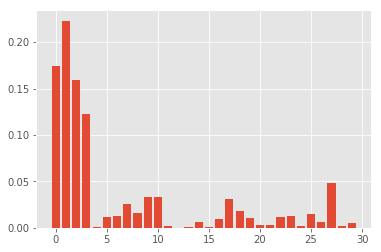

In [417]:
plt.bar(range(len(columns)),importance)
plt.show()

In [418]:
labels = pd.DataFrame({'features':columns, 'label':range(len(columns))})
labels

features  label
0             int_rate      0
1           annual_inc      1
2                  dti      2
3          funded_amnt      3
4                    A      4
5                    B      5
6                    C      6
7                    D      7
8                    E      8
9                    F      9
10                   G     10
11            MORTGAGE     11
12                NONE     12
13               OTHER     13
14                 OWN     14
15                RENT     15
16                 car     16
17         credit_card     17
18  debt_consolidation     18
19         educational     19
20    home_improvement     20
21               house     21
22      major_purchase     22
23             medical     23
24              moving     24
25               other     25
26    renewable_energy     26
27      small_business     27
28            vacation     28
29             wedding     29

We then remove 20% of the features at a time in a ranked order based on GBM's feature importance metric then see how the new models perform using k-fold cross validation. 

In [419]:
kf = KFold(n_splits=10) # Define the split - into 4
all_trials = []
for i in range(int(np.ceil(len(columns)/6))):
    sorted_features = importance.argsort()[-(len(importance)-i*6):][::-1]
    for index, (train, test) in enumerate(kf.split(df_train)):
        x_train = df_train.iloc[train][columns].iloc[:,sorted_features]
        y_train = df_train.iloc[train]['irr']
        y_test = df_train.iloc[test]['irr']
        x_test = df_train.iloc[test][columns].iloc[:,sorted_features]

        params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
              'learning_rate': 0.01, 'loss': 'ls'}

        clf = ensemble.GradientBoostingRegressor(**params)
        clf.fit(x_train, y_train)
        gbm_predictions = clf.predict(x_test)
        df_temp = pd.DataFrame({'irr':y_test, 'gbm_predictions':gbm_predictions})
        gbm_returns = np.mean(df_temp.nlargest(1000, 'gbm_predictions')['irr'])
        all_trials.append({
            'n_features': len(x_train.columns),
            'mse': calc_train_error(x_test,y_test,clf),
            'returns': gbm_returns
        })

In [420]:
output=pd.DataFrame.from_records(all_trials)

In [421]:
output.groupby(['n_features'])['mse','returns'].mean() , output.groupby(['n_features'])['mse','returns'].var()

(                 mse   returns
 n_features                    
 6           0.045751  0.094097
 12          0.045558  0.096423
 18          0.045562  0.096966
 24          0.045561  0.096399
 30          0.045564  0.096527,                  mse   returns
 n_features                    
 6           0.000005  0.000048
 12          0.000005  0.000030
 18          0.000005  0.000032
 24          0.000005  0.000048
 30          0.000005  0.000042)

It's not clear which option is the best however we can see that 18 features beat out the 30 features in both MSE and returns while only marginally losing in accuracy to others. Below are the features that made the cut for 18 features. Below we will train a model all the features available to us and see how that performs versus the vetted model. 

In [422]:
labels[labels['label'].isin(importance.argsort()[-(18):][::-1])]

features  label
0             int_rate      0
1           annual_inc      1
2                  dti      2
3          funded_amnt      3
5                    B      5
6                    C      6
7                    D      7
8                    E      8
9                    F      9
10                   G     10
16                 car     16
17         credit_card     17
18  debt_consolidation     18
19         educational     19
22      major_purchase     22
23             medical     23
25               other     25
27      small_business     27

In [423]:
kf = KFold(n_splits=10) # Define the split - into 4
all_features_trials = []
for index, (train, test) in enumerate(kf.split(df_train)):
    x_train = df_train.iloc[train][columns_all]
    y_train = df_train.iloc[train]['irr']
    y_test = df_train.iloc[test]['irr']
    x_test = df_train.iloc[test][columns_all]

    params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}

    clf = ensemble.GradientBoostingRegressor(**params)
    clf.fit(x_train, y_train)
    gbm_predictions = clf.predict(x_test)
    df_temp = pd.DataFrame({'irr':y_test, 'gbm_predictions':gbm_predictions})
    gbm_returns = np.mean(df_temp.nlargest(1000, 'gbm_predictions')['irr'])
    all_features_trials.append({
        'n_features': len(x_train.columns),
        'mse': calc_train_error(x_test,y_test,clf),
        'returns': gbm_returns
    })

In [425]:
output2=pd.DataFrame.from_records(all_features_trials)
output2.groupby(['n_features'])['mse','returns'].mean() , output2.groupby(['n_features'])['mse','returns'].var()

(                 mse   returns
 n_features                    
 48          0.045504  0.099542,                  mse   returns
 n_features                    
 48          0.000005  0.000039)

Throwing in all the features into our model significantly outperformed the vetted model. This demonstrates the power of modern machine learning techniques. Although many of our features are clearly correlated and by traditionalist standards, often are discouraged from being used together, marginal predictive utility of each features added up to improve the prediction significantly. Also, the built-in regularization ability of GBM help curb the negative variance tradeoffs. As such, often, additional time invested in careful feature selection can sometimes make your model worse. With this confirmation in mind, I will employ all 48 features but improve the model further by tuning the parameters of the model in the next post.

Title: parameter tuning in Gradient Boosting

In the last [post](http://jameslee.posthaven.com/peer-to-peer-lending-markets-part-3-feature-selection), I discussed methods for feature selection and its merits in modern machine learning. It was apparent that while feature selection is important, methods such as Gradient Boosting has built-in regularization methods that can make aggressive pruning counterproductive. Incremental predictive utility from the features despite their short-comings such as multicoliniearty add up to make a big difference in prediction performance. As a demonstration, a model with vetted features and model with all the features were pitted against each other using performance samples from cross-validation where the one with all the features dominated the other. We will take the winning set of features and take it a step further with parameter tuning and see if it can outperform a regression model, which beat out the GBM model in this [post](http://jameslee.posthaven.com/peer-to-peer-lending-markets-part-2-using-linear-regression-and-gradient-boosting-regression-to-outperform-the-market).

Hyperparameters are model specific parameters that dictate how the training should be done. It is important to get this step right to harness the full power of the algorithm. We will use GridSearchCV function from scikitlearn which exhaustively considers all possibilities of the parameters the user provides. In an ideal scenario, different combinations of the parameters are tuned together, but that requires a lot of computation resources. So, the parametesr are tuned sequentially. 

First, we chooes a learning rate. Learning rate determines how fast or slow we travel down the downward slope in gradient descent with respect to the loss function. A lower learning rate will almost surely improve the model's performance but require more computation power. 

In [436]:
Image(url= "https://cdn-images-1.medium.com/max/1600/0*00BrbBeDrFOjocpK.")

Source: Professor Andrew Ng's Machine Learning Course

I found .01 to be sufficiently low enough and doesn't take too long for my computer. As a reference, default value is .1. With our learning rate set in place, first the number of estimators are tuned. This parameter dictates the numbe of trees that are added to the model and generally large numbers improve performance. GBM is fairly robus to overfitting so a large number can be utilized but a trade off is longer computation time. 

In [437]:
parameters = {
    "n_estimators":[50, 100, 200, 500, 1000,2000]
    }
clf_ntrees = GridSearchCV(ensemble.GradientBoostingRegressor(learning_rate=0.01, min_samples_split=300,
                                                      min_samples_leaf=50,max_depth=8,max_features='sqrt',
                                                      subsample=0.8,random_state=10), parameters, cv=5, n_jobs=-1)

In [ ]:
clf_ntrees.fit(df_train[columns_all], df_train['irr'])

In [75]:
print(clf_ntrees.best_params_, clf_ntrees.best_score_)

{'n_estimators': 100} 0.0175480686076


In [76]:
 np.linspace(60, 150, 10).astype(int)

array([ 60,  70,  80,  90, 100, 110, 120, 130, 140, 150])

In [77]:
parameters = {
    "n_estimators": np.linspace(60, 150, 10).astype(int)
    }
clf_ntrees2 = GridSearchCV(ensemble.GradientBoostingRegressor(learning_rate=0.05, min_samples_split=300,
                                                      min_samples_leaf=50,max_depth=8,max_features='sqrt',
                                                      subsample=0.8,random_state=10), parameters, cv=5, n_jobs=-1)

In [78]:
clf_ntrees2.fit(df_train[columns].iloc[:,importance.argsort()[-17:][::-1]], df_train['irr'])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=8,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=50, min_samples_split=300,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=10, subsample=0.8, verbose=0,
             warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': array([ 60,  70,  80,  90, 100, 110, 120, 130, 140, 150])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [250]:
print(clf_ntrees2.best_params_, clf_ntrees2.best_score_)

{'n_estimators': 80}


80 is the best n_trees we will move onto other parameters. The order of tuning variables should be decided carefully. You should take the variables with a higher impact on outcome first. For instance, max_depth and min_samples_split have a significant impact and we’re tuning those first.

In [80]:
np.linspace(200,1000, 5).astype(int)

array([ 200,  400,  600,  800, 1000])

In [81]:
parameters2= {
    'max_depth':  np.linspace(4, 16, 7).astype(int), 'min_samples_split': np.linspace(200,1000, 5).astype(int)
}
clf_max_min = GridSearchCV(ensemble.GradientBoostingRegressor(learning_rate=0.05, 
                                                      min_samples_leaf=50,max_features='sqrt',
                                                      subsample=0.8,random_state=10, n_estimators = 80), parameters2, cv=5, n_jobs=-1)

In [82]:
clf_max_min.fit(df_train[columns].iloc[:,importance.argsort()[-17:][::-1]], df_train['irr'])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=50, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=80, presort='auto',
             random_state=10, subsample=0.8, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': array([ 4,  6,  8, 10, 12, 14, 16]), 'min_samples_split': array([ 200,  400,  600,  800, 1000])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [85]:
print(clf_max_min.best_params_, clf_max_min.best_score_)

{'max_depth': 10, 'min_samples_split': 1000} 0.0185504482691


In [32]:
np.linspace(30,80,6)

array([ 30.,  40.,  50.,  60.,  70.,  80.])

In [93]:
np.linspace(1000,2000, 5)

array([ 1000.,  1250.,  1500.,  1750.,  2000.])

In [94]:
parameters3= {
    'max_depth':  np.linspace(9,11,3).astype(int), 'min_samples_split': np.linspace(1000,2000, 5).astype(int), 'min_samples_leaf': np.linspace(30,80,6).astype(int)
}
clf_max_min_leaves = GridSearchCV(ensemble.GradientBoostingRegressor(learning_rate=0.05, 
                                                      max_features='sqrt',
                                                      subsample=0.8,random_state=10, n_estimators = 80), parameters3, cv=5, n_jobs=-1)

In [95]:
clf_max_min_leaves.fit(df_train[columns].iloc[:,importance.argsort()[-17:][::-1]], df_train['irr'])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=80, presort='auto',
             random_state=10, subsample=0.8, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': array([ 9, 10, 11]), 'min_samples_split': array([1000, 1250, 1500, 1750, 2000]), 'min_samples_leaf': array([30, 40, 50, 60, 70, 80])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [96]:
clf_max_min_leaves.best_params_, clf_max_min_leaves.best_score_

({'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 1750},
 0.01894229830211043)

In [99]:
 np.linspace(1500,2000,6)

array([ 1500.,  1600.,  1700.,  1800.,  1900.,  2000.])

In [100]:
parameters4= {
    'max_features':  np.linspace(1,17,17).astype(int), 'min_samples_split':   np.linspace(1500,2000,6).astype(int)
}
clf_max_min_leaves_feature = GridSearchCV(ensemble.GradientBoostingRegressor(learning_rate=0.05, 
                                                      max_depth = 10, min_samples_leaf = 50, 
                                                      subsample=0.8,random_state=10, n_estimators = 80), parameters4, cv=5, n_jobs=-1)

In [101]:
clf_max_min_leaves_feature.fit(df_train[columns].iloc[:,importance.argsort()[-17:][::-1]], df_train['irr'])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=10,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=50, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=80, presort='auto',
             random_state=10, subsample=0.8, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]), 'min_samples_split': array([1500, 1600, 1700, 1800, 1900, 2000])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [102]:
clf_max_min_leaves_feature.best_params_, clf_max_min_leaves_feature.best_score_ 

({'max_features': 5, 'min_samples_split': 1900}, 0.018976727153825361)

In [103]:
parameters5= {
    'subsample':  np.linspace(.5,1,6)
}
clf_5 = GridSearchCV(ensemble.GradientBoostingRegressor(learning_rate=0.05, max_features=5,
                                                      max_depth = 10, min_samples_leaf = 50, min_samples_split = 1900,
                                                      random_state=10, n_estimators = 80), parameters5, cv=5, n_jobs=-1)

In [104]:
clf_5.fit(df_train[columns].iloc[:,importance.argsort()[-17:][::-1]], df_train['irr'])
clf_5.best_score_ , clf_5.best_params_

(0.018976727153825361, {'subsample': 0.80000000000000004})

In [133]:
np.linspace(400,600,11).astype(int)

array([400, 420, 440, 460, 480, 500, 520, 540, 560, 580, 600])

In [134]:
parameters6= {
    'n_estimators':   np.linspace(400,600,11).astype(int)
}
clf_6 = GridSearchCV(ensemble.GradientBoostingRegressor(learning_rate=0.005, max_features=5, subsample = .8,
                                                      max_depth = 10, min_samples_leaf = 50, min_samples_split = 1900,
                                                      random_state=10), parameters6, cv=5, n_jobs=-1)

In [135]:
clf_6.fit(df_train[columns].iloc[:,importance.argsort()[-17:][::-1]], df_train['irr'])
clf_6.best_score_ , clf_6.best_params_

(0.018932724498527384, {'n_estimators': 480})

In [137]:
np.linspace(100,1000,10)

array([  100.,   200.,   300.,   400.,   500.,   600.,   700.,   800.,
         900.,  1000.])

In [138]:
parameters7= {
    'n_estimators':   np.linspace(100,1000,10).astype(int)
}
clf_7 = GridSearchCV(ensemble.GradientBoostingRegressor(learning_rate=0.005, max_features=5, subsample = .8,
                                                      max_depth = 10, min_samples_leaf = 50, min_samples_split = 1900,
                                                      random_state=10), parameters7, cv=5, n_jobs=-1)

In [151]:
y_test = df_test['irr']
x_test = df_test[columns].iloc[:,importance.argsort()[-17:][::-1]]
x_train = df_train[columns].iloc[:,importance.argsort()[-17:][::-1]]
y_train = df_train['irr']

In [152]:
gbm_predictions  = clf_6.predict(x_test)
gbm_mse = mean_squared_error(y_test, gbm_predictions)

In [153]:
lm = linear_model.LinearRegression()
lm.fit(x_train, y_train)
lm_predictions = lm.predict(x_test)
lm_mse = mean_squared_error(y_test, lm_predictions)
df_temp = pd.DataFrame({'irr':y_test, 'gbm_predictions':gbm_predictions, 'lm_predictions':lm_predictions})
lm_returns = np.mean(df_temp.nlargest(100, 'gbm_predictions')['irr'])

In [154]:
df_temp = pd.DataFrame({'irr':y_test, 'gbm_predictions':gbm_predictions, 'lm_predictions':lm_predictions})

In [156]:
gbm_returns= np.mean(df_temp.nlargest(100, 'gbm_predictions')['irr'])
gbm_returns, gbm_mse

(0.1259941460563475, 0.045362766734791934)

In [158]:
lm_returns = np.mean(df_temp.nlargest(100, 'lm_predictions')['irr'])
lm_returns, lm_mse

(0.11034439297170945, 0.045644792304723548)

In [163]:
returns_trials = []
for i in range(1000):
    df_sample = df_temp.sample(1000,replace=False)
    gbm_returns= np.mean(df_sample.nlargest(100, 'gbm_predictions')['irr'])
    lm_returns = np.mean(df_sample.nlargest(100, 'lm_predictions')['irr'])
    returns_trials.append({
        'index': i,
        'gbm_returns': gbm_returns,
        'lm_returns': lm_returns
    })

In [164]:
returns_output=pd.DataFrame.from_records(returns_trials)

In [167]:
print('gbm_returns:', np.mean(returns_output['gbm_returns']),', linear regression returns:' ,np.mean(returns_output['lm_returns']))

gbm_returns: 0.10082720053696367 , linear regression returns: 0.09114647290786594


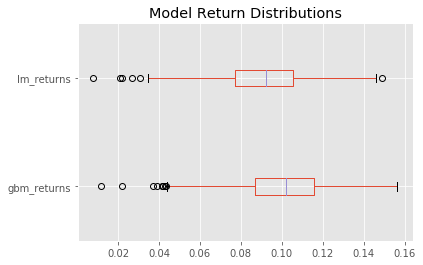

In [166]:
returns_output[['gbm_returns', 'lm_returns']].boxplot(vert=False)
plt.title('Model Return Distributions')
plt.show()